In [1]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/graph.csv
./data/submission.csv
./data/train.csv


**Change the `data_dir` to the correct data set parent directory**

In [3]:
data_dir = "data"

In [4]:
train_data_path = os.path.join(data_dir, "train.csv")
test_data_path  = os.path.join(data_dir, "test.csv")
graph_data_path = os.path.join(data_dir, "graph.csv")

**Load data sheets to `pandas.DataFrame()`**

In [5]:
train_data = pd.read_csv(train_data_path)
train_data.describe()

ID      Confirmed        Deaths      Recovered         Active  \
count  7100.000000    7100.000000   7100.000000    5771.000000    7100.000000   
mean   3549.500000   56374.339577   2323.883099   20422.274649   37635.120986   
std    2049.737788   95058.665054   4742.274729   39262.213465   79067.101832   
min       0.000000     270.000000      0.000000       0.000000    -989.000000   
25%    1774.750000    6097.500000    153.000000    1614.500000    2849.000000   
50%    3549.500000   22892.000000    681.000000    5881.000000   10409.000000   
75%    5324.250000   62959.250000   2334.000000   26103.000000   32106.500000   
max    7099.000000  712475.000000  32957.000000  507499.000000  699453.000000   

       Incident_Rate  People_Tested  People_Hospitalized  Mortality_Rate  \
count    7100.000000   7.100000e+03          5047.000000     7100.000000   
mean      747.273790   6.427069e+05          6250.044185        3.653231   
std       637.397470   1.127555e+06         13880.694435        2.074042   
min        32.771004   5.459000e+03            10.000000        0.000000   
25%       224.815702   1.000775e+05           595.000000        1.928925   
50%       540.836745   2.643235e+05          2068.000000        3.362027   
75%      1126.282666   7.048395e+05          6134.500000        4.797564   
max      3187.773001   1.137330e+07         89995.000000        9.741481   

       Testing_Rate  Hospitalization_Rate  
count   7100.000000           5047.000000  
mean    9666.099116             12.197144  
std     7779.560336              5.255183  
min      460.300152              2.302896  
25%     3379.288445              8.387037  
50%     7842.820591             11.351161  
75%    14127.521137             15.396088  
max    49502.860687             38.501190

## Now let's visualize some <br>S.H.I.T. (Scatterplots and Histograms that Interpret the Trend)

In [6]:
# First, we will get the total confirmed/deaths of each state
states = list(np.unique(train_data['Province_State']))
collected = ['Confirmed', 'Deaths', 'People_Tested']
states_data = dict.fromkeys(states, None)

for s in states:
    df_filter = train_data['Province_State'] == s
    state_df = train_data[df_filter]
    states_data[s] = state_df.drop(['Date','ID', 'Province_State', 'Recovered', 'People_Hospitalized', 'Hospitalization_Rate'], 1)
    save_columns = states_data[s].columns
    scaler = StandardScaler()
    states_data[s] = scaler.fit_transform(states_data[s])
    states_data[s] = pd.DataFrame(states_data[s], columns=save_columns)

In [7]:
states_data['California']

Confirmed    Deaths    Active  Incident_Rate  People_Tested  \
0    -1.126524 -1.568092 -1.119196      -1.126505      -1.202747   
1    -1.121363 -1.546680 -1.114295      -1.121302      -1.202588   
2    -1.114888 -1.531345 -1.107963      -1.114775      -1.199327   
3    -1.108845 -1.504436 -1.102255      -1.108683      -1.195215   
4    -1.104343 -1.476658 -1.098125      -1.104144      -1.186602   
..         ...       ...       ...            ...            ...   
137   1.913187  1.914783  1.912677       1.913521       1.886294   
138   1.938467  1.951820  1.937763       1.938811       1.912848   
139   1.959608  1.977572  1.958825       1.959959       1.941352   
140   1.977387  1.990013  1.976684       1.977744       1.976538   
141   2.007029  2.014608  2.006399       2.007397       2.017275   

     Mortality_Rate  Testing_Rate  
0         -0.105361     -1.202976  
1          0.089968     -1.202815  
2          0.135665     -1.199528  
3          0.355231     -1.195384  
4          0.612357     -1.186701  
..              ...           ...  
137       -1.194190      1.886579  
138       -1.190039      1.913141  
139       -1.189475      1.941654  
140       -1.194020      1.976851  
141       -1.199411      2.017600  

[142 rows x 7 columns]

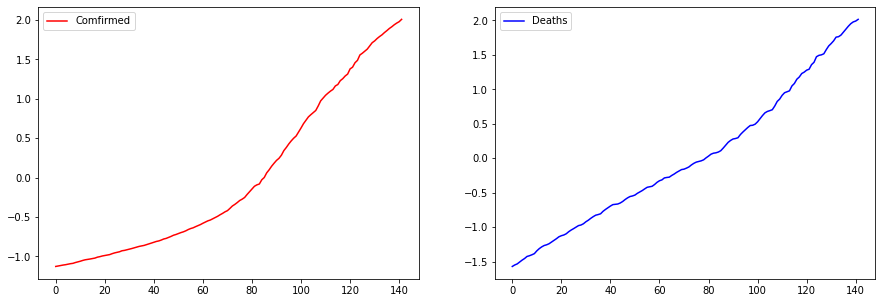

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(states_data['California'].Confirmed.values, color='red', label='Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data['California'].Deaths.values, color='blue', label='Deaths')
plt.legend(loc='best')


## Create Cross-validation Datasets

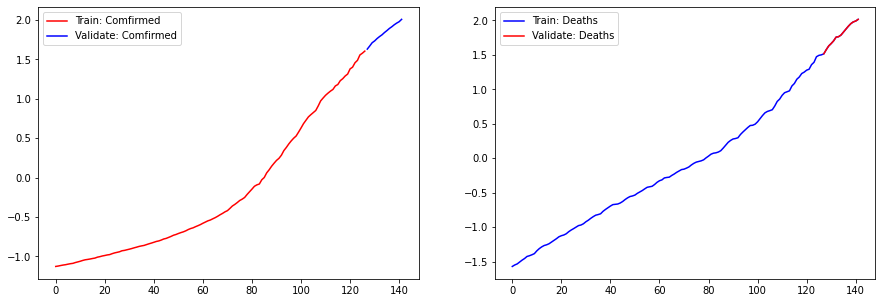

In [9]:
test_percentage = 0.9
validate_percentage = 0.1
state_train_data = {}
state_validate_data = {}

for state in states_data.keys():
    state_data_size = states_data[state].shape
    state_test_size = math.floor(state_data_size[0]*test_percentage)
    state_train_data[state] = states_data[state][:state_test_size]
    state_validate_data[state] = states_data[state][state_test_size:]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data['California'].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(np.arange(state_train_data['California'].shape[0], state_train_data['California'].shape[0]+state_validate_data['California'].shape[0]), state_validate_data['California'].Confirmed.values, color='blue', label='Validate: Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data['California'].Deaths.values, color='blue', label='Train: Deaths')
plt.plot(np.arange(state_train_data['California'].shape[0], state_train_data['California'].shape[0]+state_validate_data['California'].shape[0]), state_validate_data['California'].Deaths.values, color='red', label='Validate: Deaths')
plt.legend(loc='best')

## Train a RNN model